## Diagnostic of Full version of Kuang's model

### Using package

In [1]:
using Pkg;
Pkg.activate("/work/b11209013/external/JuliaENV/atmo/");

using Plots, Measures; gr();
using FFTW, LinearAlgebra, Statistics;
using LazyGrids;

default(
    size=(1600,900),
    bottom_margin=10mm,
    left_margin=10mm,
    top_margin=10mm,
    right_margin=10mm,
    titlefont=font(32,"times"),
    guidefont=font(28,"times"),
    tickfont=font(24,"times"),
)

  Activating project at `/work/b11209013/external/JuliaENV/atmo`


### Functions

#### System Matrix

In [2]:
function sys_matrix(
    k :: Float64;
    ϵ=ϵ, c1=c1, c2=c2,
    a1=a1, a2=a2, d1=d1, d2=d2, rq=rq, r0=r0,
    A=A, B=B, f=f, τL=τL
    )

    α :: ComplexF64 = 1.5*rq*(d1+d2);
    β :: ComplexF64 = -rq*(d1-d2);
    γ :: ComplexF64 = -1*((d1-d2)*r0 + (d1+d2));

    mat :: Matrix{ComplexF64} = [
    -ϵ 0.0 (c1*k)^2 0.0 0.0 0.0;
    0.0 -ϵ 0.0 (c2*k)^2 0.0 0.0;
    -1.0 0.0 -1.5*rq 0.0 rq 1+r0;
    0.0 -1.0 1.5*rq 0.0 -rq 1-r0;
    a1 a2 α 0.0 β γ;
    f/B/τL (1-f)/B/τL -1.5*A*rq/B/τL 0.0 A*rq/B/τL -1.0/τL
                                ];
    return mat
end

sys_matrix (generic function with 1 method)

#### Non-Modal Stability

In [ ]:
function nonmodal_grwoth(kn::Float64)

    mat :: Matrix{ComplexF64} = sys_matrix(kn);

    unit_vec :: Matrix{ComplexF64} = ones(ComplexF64, 6,1);
    sys_mat  :: Matrix{ComplexF64} = exp(mat);
    pred_vec :: Matrix{ComplexF64} = exp(mat)*unit_vec;

    amp_factor :: Matrix{ComplexF64} = (pred_vec'*pred_vec) * inv(unit_vec'*unit_vec)

    return real.(amp_factor[1,1])
end

modal_growth (generic function with 1 method)

#### Modal Stability

In [ ]:
function modal_growth(kn::Float64)

    mat    :: Matrix{ComplexF64} = sys_matrix(kn);

    gr     :: Vector{Float64}    = real.(eigvals(mat));

    return maximum(gr)
end

nonmodal_growth (generic function with 1 method)

### Set constant

In [5]:
const b1 :: Float64 = 1.0;
const b2 :: Float64 = 2.0;

const a1 :: Float64 = 1.4;
const a2 :: Float64 = 0.0;

const d1 :: Float64 = 1.1;
const d2 :: Float64 = -1.0;

const m1 :: Float64 = 0.3;
const m2 :: Float64 = 1.0;

const r0 :: Float64 = 1.0;
const rq :: Float64 = 0.7;

const F  :: Float64 = 4.0;
const f  :: Float64 = 0.5;

const τL :: Float64 = 1/12;
const c1 :: Float64 = 1.0;
const c2 :: Float64 = 0.5;

const ϵ  :: Float64 = 0.1;

const Γ  :: Float64 = 6.5/1000.0;

const Rd :: Float64 = 287.5;
const Cp :: Float64 = 1004.5;
const g  :: Float64 = 9.81;

const A  :: Float64 = 1.0 - 2.0*f + (b2-b1)/F;
const B  :: Float64 = 1.0 + (b2+b1)/F - A*r0;

### Compute Stab. with different wavenumber

In [54]:
λ_target :: Vector{Float64} = collect(2000:500:40000);

modal_stab    :: Vector{Float64} = Array{Float64}(undef, length(λ_target));
nonmodal_stab :: Vector{Float64} = Array{Float64}(undef, length(λ_target));

# modal and non-modal growth rate
@inbounds for (i, λ) in enumerate(λ_target)
    kn :: Float64 = 2*π*4320/λ;

    modal_stab[i] = modal_growth(kn);
    nonmodal_stab[i] = nonmodal_growth(kn);
end

modal_max :: Float64 = (40000.0./λ_target)[argmax(modal_stab)];
nonmodal_max :: Float64 = (40000.0./λ_target)[argmax(nonmodal_stab)];
@show 40000.0/modal_max, 40000.0/nonmodal_max

(40000.0 / modal_max, 40000.0 / nonmodal_max) = (4500.0, 5000.0)


(4500.0, 5000.0)

### Display

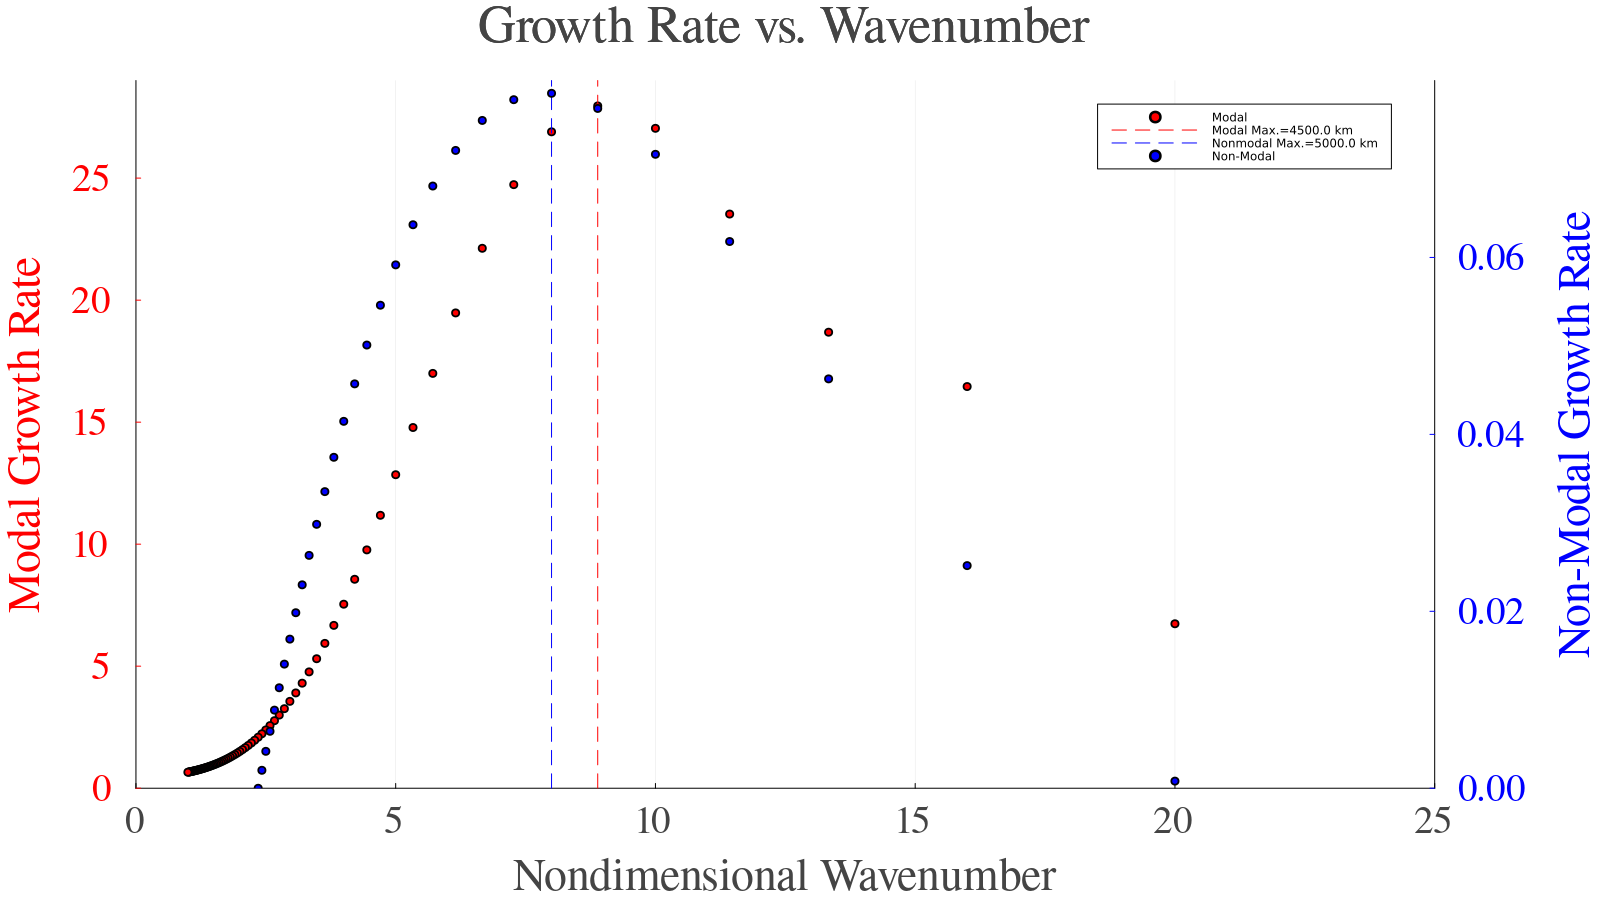

In [57]:
plt = plot(
    40000.0./λ_target, modal_stab,
    seriestype=:scatter, color="red", label="Modal",
    ylabel="Modal Growth Rate", xlim=(0,25), ylim=(0,29), legend = :topright,
    );
vline!(plt, [modal_max]; color=:red, linestyle=:dash, label="Modal Max.=4500.0 km");
xlabel!(plt, "Nondimensional Wavenumber");
plot!(plt;
    yforeground_color_axis = :red,
    yguidefont = font(color=:red,28,"times"),
    ytickfont  = font(color=:red,24,"times"),
)
vline!(plt, [nonmodal_max]; color=:blue, linestyle=:dash, label="Nonmodal Max.=5000.0 km");
plot!(
    twinx(), 40000.0./λ_target, nonmodal_stab,
    seriestype=:scatter, color="blue", label="Non-Modal",
    ylabel="Non-Modal Growth Rate", xlim=(0,25), ylim=(0,0.08), legend=false,
    yforeground_color_axis=:blue,
    yguidefont = font(color=:blue,28,"times"),
    ytickfont  = font(color=:blue,24,"times"),
    );
plot!(plt, [NaN], [NaN];
    seriestype = :scatter, color = :blue, marker = :circle,
    label = "Non-Modal",
)
xlims!(plt, (0, 25));

# ylabel!(plt, "Growth Rate")
title!(plt, "Growth Rate vs. Wavenumber");
savefig(plt, "/home/b11209013/2025_Research/MSI/Fig/Full_Modal.png");
display(plt);